In [1]:
# importing packages

# data manipulation
import numpy as np

# plotting and image exporting
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
# %matplotlib notebook
import time

# letting me know when large calculations are done
import winsound

import spot_functions_for_plotting as sf

# creating a basic normalization function which sets the minimum entry to zero and the maximum entry to one
def normalize(a):
    if np.min(a) != np.max(a):
        return (a - np.min(a)) / (np.max(a) - np.min(a))
    else:
        return a

# numpy version of converting right ascention and declination to cartesian coordinates on unit celestial sphere
# conversion from https://en.wikipedia.org/wiki/Equatorial_coordinate_system
def lon_lat_2_cart(lon, lat):
    return np.array([np.cos(lat) * np.cos(lon), np.cos(lat) * np.sin(lon), np.sin(lat)])

# create a 3D figure (for cool plots)
def init_3D_figure(figsize=[16, 16]):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    return fig, ax

# initialize a large 2D figure with large labels. wide affects aspect ratio. plot_size changes the overall size
def init_plot(plot_size=1, wide=1):
    
    # create figure
    fig = plt.figure(figsize=[16 * plot_size * wide, 16 * plot_size])
    
    # make labels easy to work with
    ax = plt.subplot(111)

    # change label sizes
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(40 * plot_size)

    # return ax so the labels can be set
    return ax

# show the plot and save it if they want
def finish_plot(fig_name=""):

    # show plot
    fig = plt.gcf()

    # save it at the specified location
    if fig_name!="":
        fig.savefig(fig_name, bbox_inches="tight")
        
def spot_color(point, spot_centers, spot_radii):
#     assert np.isclose(np.linalg.norm(point), 1)
#     assert np.isclose(np.linalg.norm(spot_centers, axis=1), np.ones(len(spot_radii))).all
#     assert len(lat)==len(lon)
#     assert np.shape(spot_centers)[0]==len(spot_radii)
    # cos_spot_radii = np.cos(1e-3 * np.sqrt(2 * msh * np.pi))
    # spot_radii = sf.msh2r_star(msh)
    hold = spot_radii - np.array([np.arccos(np.dot(point, spot_centers[i,:])) for i in range(len(spot_centers))])
    return sum((1 + hold[hold>0]/spot_radii[hold>0])/2)
    # return sum(np.array([np.dot(point, spot_centers[i,:]) for i in range(len(spot_centers))]) > cos_spot_radii)
    
PROT=25.05
def diff_rotate_z(point, t):
    lat = np.arcsin(point[2])
    P = 1/((360 / PROT - 2.396 * (np.sin(lat) ** 2) - 1.787 * (np.sin(lat) ** 4))/360)
    theta = 2 * np.pi * t / P
    point_copy = np.copy(point)
    point_copy[0] = point[0] * np.cos(theta) + point[1] * np.sin(theta)
    point_copy[1] = point[0] * -np.sin(theta) + point[1] * np.cos(theta)
    
    return point_copy

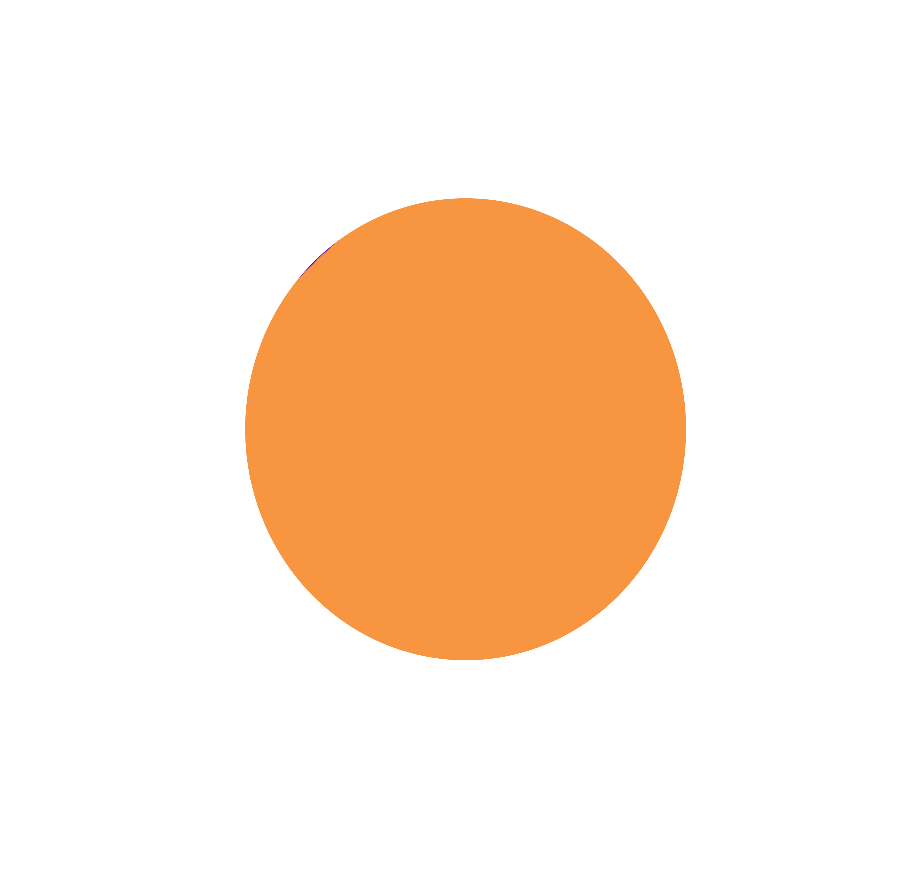

In [2]:
# Jones spot

# whether or not to animate (prevents accidents)
animate = False

# how detailed the sphere should be
fine = 100

# evenly spaced RA and dec to build a mesh grid for surface plot
lat = np.linspace(-np.pi / 2, np.pi / 2, fine)
lon = np.linspace(0, 2 * np.pi, fine)
lat, lon = np.meshgrid(lat, lon)

# get values of the contructed probability density function at each point
fcolors = np.zeros((fine, fine))
test = lon_lat_2_cart(lon, lat)

true_centers = np.array([lon_lat_2_cart(np.pi, 40/360 * 2 * np.pi)])
msh = np.array([1e4])
spot_radii = sf.msh2r_star(msh)
for i in range(fine):
    for j in range(fine):
        fcolors[i, j] = spot_color(test[:, i, j], true_centers, spot_radii)
# save = np.copy(fcolors)
fcolors = 0.75 * normalize(-fcolors)

# initialize plot
fig, ax = init_3D_figure()

# plot surface
ax.plot_surface(test[0, :, :], test[1, :, :], test[2, :, :],  rstride=1, cstride=1, facecolors=cm.plasma(fcolors), shade=False)

#turn off axes and show plot
ax.set_axis_off()
plt.show()

amount_of_pics = 10

if animate:
    
    # for each angle
    for i in range(amount_of_pics):
        print(i / amount_of_pics)

        # rotate and redraw plot
        ax.view_init(0, 2 * np.pi * i / amount_of_pics)
        plt.draw()
        
        # set a pause so nothing weird happens
        plt.pause(.001)
        
        # show and save the plot frame
        fig = plt.gcf()
        fig.savefig("gifs/jones/test_%d.png"%i, bbox_inches="tight")

    # open all of the images
    images=[]
    for i in range(amount_of_pics):
        images.append(Image.open("gifs/jones/test_%d.png"%i))

    # combine the images into a gif
    images[0].save('gifs/jones/anitest.gif',
                   save_all=True,
                   append_images=images[1:],
                   duration=50,
                   loop=0)

plt.close('all')

In [7]:
# variable spots

# whether or not to animate (prevents accidents)
animate = False

# how detailed the sphere should be
fine = 200

# evenly spaced RA and dec to build a mesh grid for surface plot
lat = np.linspace(-np.pi / 2, np.pi / 2, fine)
lon = np.linspace(0, 2 * np.pi, fine)
lat, lon = np.meshgrid(lat, lon)

# get values of the contructed probability density function at each point
fcolors = np.zeros((fine, fine))
test = lon_lat_2_cart(lon, lat)

obs_n_days = PROT * 2  # create spots for 2 equatorial rotation periods

time_samps = 120
spot_dens_mult = 1  # multiplies the realistic amount of spots being generated
spot_len_mult = 2  # multiplies the lifetime of spots in plots
spot_rad_mult = 4  # multiplies the radius of the spots in the plots
star_rot_mult = 1  # modifies how fast the spots rotate

# get_spots() Spot Parameters - except N_spots, all variables are either arrays of
# size N_spots or None (None indicates randomly generates values).
spot_density = spot_dens_mult * 109  # 4                            # avg no. of spot initializations per rotation period
spot_start, N_spots = sf.start_times(spot_density, obs_n_days/365.25) # starting times of spots (years)
spot_Long = 360*np.random.random(N_spots)   # spot longitudes (degrees)
spot_Lat = sf.spot_latitudes(N_spots)       # spot latitudes (degrees)
spot_Amp, spot_Types = sf.spot_amplitudes(N_spots)      # spot max amplitudes (units of R_star)
spot_gf = [0.1]*N_spots  # [0.33]*N_spots   # Ratio of growth/(growth + decay) of spot. 0-1 range # from Howard 1992, referenced in Borgniet 2015
spot_len = sf.spot_lifetime(spot_Amp, spot_Types, spot_gf)        # lifetime (length) of spot (units of years)
spot_func = 'parabolic'   
print("Amount of spots generated is approximately: " + str(N_spots))

PSI_time = np.linspace(0, obs_n_days, num=time_samps)
PSI = sf.time_to_phase(PROT, PSI_time, time_unit='day')
size_ph_all = np.zeros((N_spots, time_samps))

for i in range(N_spots):
    start_ph = sf.time_to_phase(PROT, spot_start[i], 'year')
    length_ph = sf.time_to_phase(PROT, spot_len[i], 'year')
    # spot size and lifetime exagerated in plots!
    size_ph_all[i,:] = sf.spot_size_gen(PSI, start_ph, spot_len_mult * length_ph, spot_rad_mult *spot_Amp[i], spot_gf[i], spot_func)

Amount of spots generated is approximately: 218
**starspot phases severely outside observing range, **SKIPPING**
**starspot phases severely outside observing range, **SKIPPING**
**starspot phases severely outside observing range, **SKIPPING**
**starspot phases severely outside observing range, **SKIPPING**


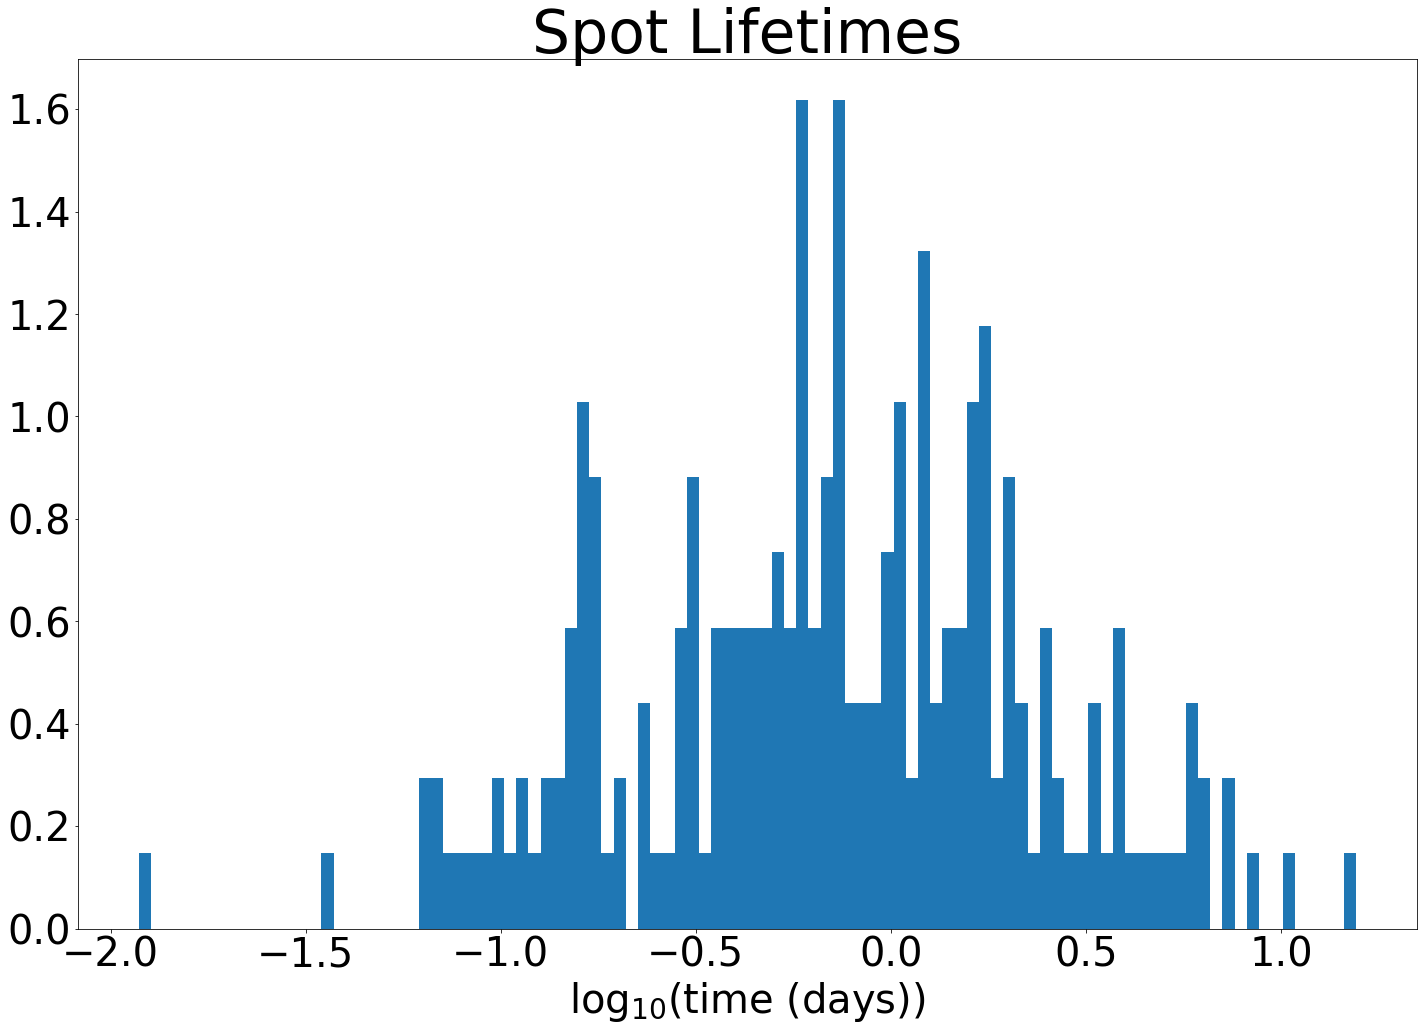

In [8]:
# plot the spot lifetime distribution if you want

init_plot(plot_size=1, wide=1.5)
# plt.hist(np.log10(sf.spot_lifetime(spot_Amp, spot_Types, spot_gf) * 365.25), bins=100, density=True, log=True)
plt.title("Spot Lifetimes", fontsize=60)
plt.hist(np.log10(spot_len * 365.25), bins=100, density=True)
plt.xlabel(r"$\log{}_{10}$(time (days))")
finish_plot(fig_name="spot_lifetimes.png")

C:\Users\Christian\Miniconda3\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in greater


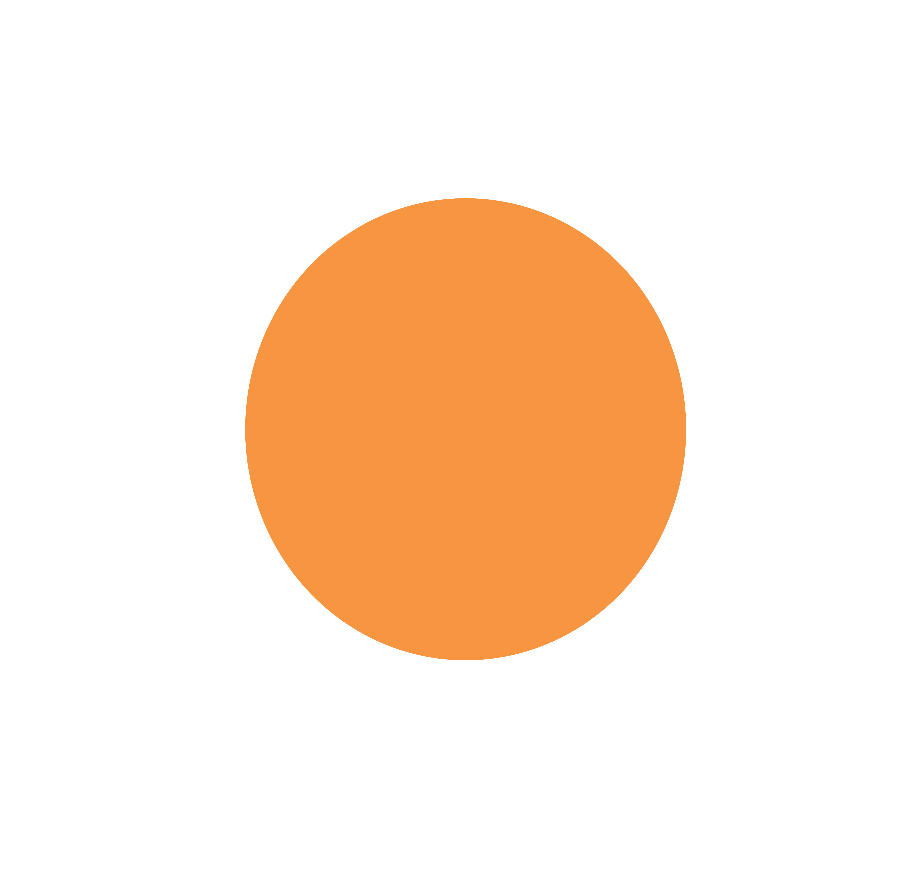

In [9]:
if not animate:
    
    true_centers = np.array([lon_lat_2_cart(spot_Long[i], spot_Lat[i]) for i in range(N_spots)])
    spot_radii =size_ph_all[:,0]  # spot size greatly exagerated!

    for i in range(fine):
        for j in range(fine):
            fcolors[i, j] = spot_color(test[:, i, j], true_centers, spot_radii)
    # save = np.copy(fcolors)

    if sum(sum(fcolors))==0:
        fcolors += 0.75
    else:
        fcolors = 0.75 * normalize(-fcolors)

    # initialize plot
    fig, ax = init_3D_figure()

    # plot surface
    ax.plot_surface(test[0, :, :], test[1, :, :], test[2, :, :],  rstride=1, cstride=1, facecolors=cm.plasma(fcolors), shade=False)

    #turn off axes and show plot
    ax.set_axis_off()
    plt.show()
    
else:
    start = time.time()
    
    for k in range(time_samps):
        print(float(k) / time_samps)

        true_centers = np.array([lon_lat_2_cart(spot_Long[i], spot_Lat[i]) for i in range(N_spots)])
        true_centers = np.array([diff_rotate_z(center, star_rot_mult * PSI_time[k]) for center in true_centers])
        spot_radii = spot_rad_mult * size_ph_all[:,k]  # spot size greatly exagerated!

        for i in range(fine):
            for j in range(fine):
                fcolors[i, j] = spot_color(test[:, i, j], true_centers, spot_radii)
        # save = np.copy(fcolors)

        if sum(sum(fcolors))==0:
            fcolors += 0.75
        else:
            fcolors = 0.75 * normalize(-fcolors)

        # initialize plot
        fig, ax = init_3D_figure()
        
        # plot surface
        ax.plot_surface(test[0, :, :], test[1, :, :], test[2, :, :],  rstride=1, cstride=1, facecolors=cm.plasma(fcolors), shade=False)
        ax.set_axis_off()
        
        ax.view_init(0, 0)

        # set a pause so nothing weird happens
        plt.pause(.001)
        
        # show and save the plot frame
        # fig = plt.gcf()
        fig.savefig("gifs/var/test_%d.png"%k, bbox_inches="tight")
        # plt.close()
        current = (time.time() - start) / 60 * (time_samps/(k + 1) - 1)
        print("estimated time to completion: %0.2f minutes"%current)

    # open all of the images
    images = [Image.open("gifs/var/test_%d.png"%i) for i in range(time_samps)]

    # combine the images into a gif
    images[0].save('gifs/var/anitest.gif',
                   save_all=True,
                   append_images=images[1:],
                   duration=50,
                   loop=0)
    
    plt.close('all')
    frequency = 262  # Set Frequency (Hz), middle C
    duration = 1000  # Set Duration To 1000 ms == 1 second
    winsound.Beep(frequency, duration)